# Imports

In [215]:
import os
import time
import warnings
from IPython.display import clear_output

import numpy as np
import pandas as pd
from pandarallel import pandarallel

import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from wordcloud import WordCloud
import pprint
from PIL import Image

from nltk.corpus import stopwords

from scipy.sparse import csr_array

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Configuration

In [163]:
# PREVIEW PHASE
PREVIEW_REVIEW_SIZE = 1000

# EXTRACT PHASE
CHUNK_SIZE = 10000
EXTRACT_PARQUET = True

# SAMPLINg
SAMPLING_REVIEW_SIZE = 1000
SAMPLING_PHOTOS_SIZE = 100

ORIGINAL_DATASET_DIR = 'data/original/yelp_dataset/'
ORIGINAL_PHOTOS_DIR = 'data/original/yelp_photos/'
WORK_DATASET_DIR = 'data/work/yelp_dataset/'
PREFIX_YELP = 'yelp_academic_dataset_'

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
sns.set()

# Fonctions

In [112]:
def time_from(time_start):
    time_total = round(time.time() - time_start, 0)
    minutes = time_total // 60
    seconds = time_total - minutes * 60
    return f'{minutes:.0f}mn {seconds:.0f}s'
    
def list_files(dir, extension='json', print_result = True):
    paths = {(file.split('.')[0]).split(PREFIX_YELP)[1]: dir + file for file in os.listdir(dir) if file.endswith('.' + extension)}
    if print_result:
        files = [[os.path.basename(paths[name]), file_size(paths[name])] for name in paths]
        print(tabulate(files, headers=['Name', 'Size']))
    return paths

def file_size(path, unit='Gb', precision=2, only_value = False):
    exp = 3
    if (unit=='ko'):
        exp = 1
    elif (unit == 'Mb'):
        exp = 2
    else:
        exp = 3
        unit = 'Gb'

    value = round((os.path.getsize(path)/(1024**exp)), precision)
    if only_value:
        return value
    else:
        return str(value) + unit

def preview_dataset(path):
    df = pd.read_json(path, lines=True, nrows=PREVIEW_REVIEW_SIZE)
    display(df.sample(5))
    display(df.dtypes)

    return df   

def get_negative_sw():
    return [sw for sw in stopwords.words('english') if sw not in ['not', 'too', 'very', 'few',  "don't", "aren't", 'couldn',
                                                                  "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',
                                                                  "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn',
                                                                  "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn',
                                                                  "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
                                                                  "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
           ]

def get_stop_words(reviews: pd.DataFrame, min_df = 1, max_df = 0, verbose = 0):
    words = {}
    for index in reviews.index:
        for token in reviews.loc[index, 'tokens']:
            if token not in words:
                words[token] = 1
            else:
                words[token] = words[token] + 1

    words = dict(sorted(words.items(), key=lambda item: item[1]))

    # Remove english stop word
    english_sw = stopwords.words('english')
    words_wo_sw = {token:words[token] for counter, token in enumerate(words) if token not in english_sw}

    # Drop most frequent
    most_frequent = [[token, words_wo_sw[token]] for counter,token in enumerate(words_wo_sw) if counter > len(words_wo_sw) - max_df - 1]
    if verbose > 1 : 
        print(f'Les {max_df} mots les plus fréquents:')
        print(tabulate(most_frequent[::-1], headers=['mot', 'Nombre d\'apparitions']))
        print('')

    # Drop frequency under
    frequency_under = [token for token, count in words_wo_sw.items() if count < min_df]
    if verbose > 1:
        print(f'{len(frequency_under)} mots apparaissent moins de {min_df} fois:')
        np_treshold = np.get_printoptions()['threshold']
        np.set_printoptions(threshold=20)
        print(np.array(frequency_under))
        np.set_printoptions(threshold=np_treshold)
        print('')

    sw = list(set(stopwords.words('english') + list(np.array(most_frequent).T[0]) + frequency_under))

    return sw, len(words)      

def drop_words(tokens, words):
    return [token for token in tokens if token not in words]

def preprocess_text(text):
    # normalization
    text = text.lower().strip()

    return text 

def tokenize(text):
    from nltk import RegexpTokenizer
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

    # Tokenization
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)

    # Lematization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos='a') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='n') for word in tokens]

    # Keep tokens with length > 2
    tokens = [token for token in tokens if len(token) > 2]

    return tokens

def word_cloud(text):
    wordcloud = WordCloud(background_color = 'white', max_words = 50).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show();

def get_vocabulary_matrix(reviews: pd.DataFrame):
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    for review in list(reviews['tokens']):
        for token in review:
            index = vocabulary.setdefault(token, len(vocabulary))
            indices.append(index)
            data.append(1)
        indptr.append(len(indices))
    csr = csr_array((data, indices, indptr), dtype=int).toarray()

    return csr

def get_topics(reviews: pd.DataFrame, model = 'lda', min_df = 4, max_df = 10, n_topics = 10, n_top_words = 10, ngram_range=(1,1), verbose = 0):

    if verbose > 1: print('  - Vectorisation (tf-idf)')
    vectorizer = TfidfVectorizer(tokenizer=tokenize, token_pattern=None, preprocessor=preprocess_text, min_df=min_df, max_df=max_df, stop_words=get_negative_sw(), sublinear_tf=True,ngram_range=ngram_range)
    values = vectorizer.fit_transform(reviews['text'])

    # Topics from LDA or MDF
    if model == 'lda':
        if verbose > 1: print('  - Modélisation LDA')
        model = LatentDirichletAllocation(n_components=n_topics,
                                          max_iter=5, 
                                          learning_method='online', 
                                          learning_offset=50.,
                                          random_state=0,
                                          n_jobs=-1)
    if model == 'nmf':
        if verbose > 1: print('  - Modélisation NMF')
        model = NMF(n_components=n_topics, 
                    random_state=0,)
    
    model.fit(values)

    if verbose > 1: print('  - Affichage des topics\n')
    topics = []
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append([topic_idx, ', '.join(features)])
    
    if verbose > 0: print(tabulate(topics, headers=['Topic n°', 'Categories']))

    return topics

# Extractions des sujets des reviews

## Prévisualiastions des datasets

In [6]:
files = list_files(ORIGINAL_DATASET_DIR)
print('')
print(tabulate([[k,v] for k,v in files.items()]))

Name                                 Size
-----------------------------------  ------
yelp_academic_dataset_business.json  0.11Gb
yelp_academic_dataset_checkin.json   0.27Gb
yelp_academic_dataset_review.json    4.98Gb
yelp_academic_dataset_tip.json       0.17Gb
yelp_academic_dataset_user.json      3.13Gb

--------  --------------------------------------------------------------
business  data/original/yelp_dataset/yelp_academic_dataset_business.json
checkin   data/original/yelp_dataset/yelp_academic_dataset_checkin.json
review    data/original/yelp_dataset/yelp_academic_dataset_review.json
tip       data/original/yelp_dataset/yelp_academic_dataset_tip.json
user      data/original/yelp_dataset/yelp_academic_dataset_user.json
--------  --------------------------------------------------------------


In [7]:
preview_dfs = {}
for name in files:
    print(f'PREVIEW {name}\n=====================\n')
    preview_dfs[name] = preview_dataset(files[name])
    print('')

PREVIEW business



,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
528,kxvOUehCtJAL2nYKkeiR-w,Incrediplex,6002 Sunnyside Rd,Indianapolis,IN,46236,39.866083,-85.975098,4.0,33,0,"{'GoodForKids': 'True', 'BusinessAcceptsCredit...","Specialty Schools, Education, Gyms, Sports Clu...","{'Monday': '0:0-0:0', 'Tuesday': '12:0-22:0', ..."
90,-ZXYcCyDjj1QimnJyGtYtg,Gilley's Antique Mall,5789 E US Hwy 40,Plainfield,IN,46168,39.694993,-86.423071,4.5,24,1,"{'RestaurantsPriceRange2': '2', 'ByAppointment...","Home Decor, Shopping, Antiques, Books, Mags, M...","{'Monday': '10:0-17:0', 'Tuesday': '10:0-17:0'..."
510,RZpEMG2ILk4bL3lH3ygRcw,Medford Village Car Care,11 N Main St,Medford,NJ,08055,39.899973,-74.823137,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'WiFi':...","Automotive, Auto Repair, Tires, Body Shops, Oi...","{'Monday': '0:0-0:0', 'Tuesday': '7:30-17:30',..."
650,O0YHVrUtxbsEhQ4qaWkVaw,Boston Pizza,10115 Princess Elizabeth Avenue NW,Edmonton,AB,T5G 0X9,53.569500,-113.494179,2.5,6,0,"{'GoodForKids': 'False', 'RestaurantsTakeOut':...","Italian, Restaurants, Pizza",None
184,YD_eZ4TaFrHYRrJVzOXHfw,Passport Health,"1034 S Brentwood Blvd, Ste 710",Saint Louis,MO,63117,38.636197,-90.345754,1.5,11,1,"{'ByAppointmentOnly': 'True', 'BusinessAccepts...","Medical Centers, Health & Medical","{'Monday': '9:0-17:0', 'Tuesday': '9:0-17:0', ..."


business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
attributes       object
categories       object
hours            object
dtype: object


PREVIEW checkin



,business_id,date
473,-D5XxdkNwCE65dX_aybvog,"2016-04-20 15:15:30, 2017-11-02 20:28:39"
412,-BHSeNtP6CoErp30iGDxPg,"2011-07-10 16:49:44, 2011-09-29 18:15:23, 2011..."
73,-1-8eimDEnS9fezJNZkQkQ,"2020-05-23 14:57:09, 2020-05-24 07:42:44"
368,-9zDI4h2dE3hFOpGFHB10Q,"2019-10-20 12:30:32, 2019-10-24 23:40:39, 2019..."
496,-DnuxdcataKWVrxzGAlj2g,"2013-01-27 02:45:50, 2014-01-24 00:23:51, 2014..."


business_id    object
date           object
dtype: object


PREVIEW review



,review_id,user_id,business_id,stars,useful,funny,cool,text,date
999,HBCwI0ahXuni3x030HGKFA,WKe2b_EeLBnZ3lZV5WKYGQ,-Or44IdY51Ukd618kikmtA,4,0,0,0,My friends and I all got one of each that were...,2016-07-25 06:28:49
166,0-lnwfRh1GA1Lvu5RRC9Cg,xXYNgEWnjaim2byFGLex-w,7WZ5EGb-Xk_uxQTWc52P4w,5,2,0,0,Back to Tom Jones and time to update my review...,2012-06-26 02:49:39
353,PCxW8IqqvCODd9Tr_XFjlQ,_LG_1zjLB8gWjN294Xjc5Q,WmzwJXyBdqsZCZ254XDrtQ,5,0,0,1,Becca is an awesome bartender. They have aweso...,2016-08-03 22:50:36
953,ly8zfN5hp4s57_MfL6sOEA,IlizsR-UvmFa1V9iskTYjg,geUiM_VTRmUz6dViO7E-jg,5,1,0,1,"I'm picky when it comes to pizza, and Brixx is...",2017-07-18 22:48:44
803,39n06H82AMK1_bOPGJJHug,Y1T7sd4TKOe4utqV5hFdMQ,7UtzYHLViVa5WJW992f3fg,3,2,0,1,I could say that this is a touch of Italy in a...,2012-07-16 13:31:34


review_id              object
user_id                object
business_id            object
stars                   int64
useful                  int64
funny                   int64
cool                    int64
text                   object
date           datetime64[ns]
dtype: object


PREVIEW tip



,user_id,business_id,text,date,compliment_count
268,HAApeWFR7aBy0OGT2Y4Qvg,ZewrmVIdr77Kinj-njv6RQ,Addictive! Hot cookies that taste amazing. N...,2016-08-20 18:21:19,0
997,uRHG1p9dkcWSRoxiCZV2mw,Wxcz9GHVfLUhER5FQAEDng,I really like some healthier fast options.,2016-01-13 00:03:00,0
261,_YqknhseJ6yjtS1g0D4Vwg,TZG_XV9u4xgE56s0otXEag,Huge menu like cheesecake factory. Beer not s...,2015-02-10 17:59:56,0
621,DsT5MBye39a3hYel-pCfBg,hMoFsCFz1vBDaglH0Qvwwg,Truly a garden of brew.,2011-08-05 22:57:13,0
961,qQ2C1smfFLSxbe-BsD00ow,Adk7onX_5mfD_HWmUEAhmA,Excellent service and food !,2017-09-28 21:29:05,0


user_id                     object
business_id                 object
text                        object
date                datetime64[ns]
compliment_count             int64
dtype: object


PREVIEW user



,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
414,xzvTed9al7cOEc0S57kb3w,Tina,584,2008-05-01 06:11:26,515,264,228,"2010,2011,2012,2013,2014,2015,2016","4iMzkb26_UFJeoV9qiPYhA, VTmjH9QyUyhXzKvyXJn3RQ...",23,...,2,1,3,0,12,26,17,17,7,3
481,GYklwfO3N5BXeZ1RjHPDJA,Jose,96,2007-05-21 05:50:56,172,30,53,,"31Y-XTyubC8k7NR7MIJe4w, 5uk2dh65HBPg9pmesoBjXA...",5,...,0,0,0,0,4,5,5,5,1,0
293,D6bq08PeNGV_WkZbO572Bg,Gerald,9,2006-07-12 00:35:31,5,0,3,,"ReoITf9K798Y_1aat7zh-Q, 9H-Fu2rcMOpzO7g8kB9drw...",1,...,0,0,0,0,0,0,0,0,1,0
244,JOwThWdv2KZCO_u9MieR1g,Aaron,38,2007-08-02 19:53:56,167,93,138,2008,"QBaeoagSm3RhtGilbJLdnQ, dAsJLX2nG0pyDmsaer7iiw...",3,...,2,0,0,0,7,4,13,13,0,1
775,4LO6X_jyG5BCo4AD_rtKAA,Kelsi,14,2010-07-25 18:58:49,13,7,3,,"TqJVI1r84G7pGYLMyXE25Q, M6Suq__QXOc_DmRoMa2_Sw...",3,...,0,0,0,0,1,1,0,0,0,0


user_id                object
name                   object
review_count            int64
yelping_since          object
useful                  int64
funny                   int64
cool                    int64
elite                  object
friends                object
fans                    int64
average_stars         float64
compliment_hot          int64
compliment_more         int64
compliment_profile      int64
compliment_cute         int64
compliment_list         int64
compliment_note         int64
compliment_plain        int64
compliment_cool         int64
compliment_funny        int64
compliment_writer       int64
compliment_photos       int64
dtype: object

<Axes: xlabel='stars'>

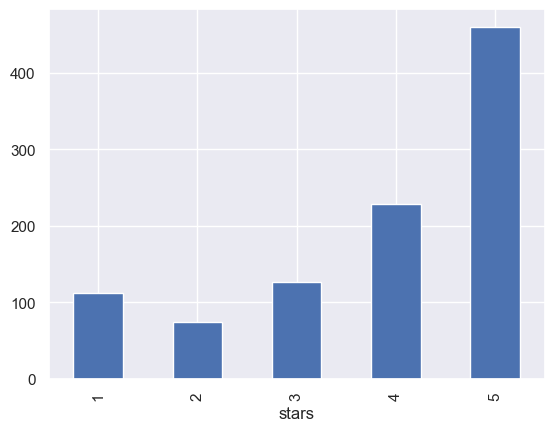

In [8]:
preview_dfs['review']['stars'].value_counts().sort_index().plot.bar()

In [9]:
preview_dfs['business']['categories'].unique()[0:20]

array(['Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists',
       'Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services',
       'Department Stores, Shopping, Fashion, Home & Garden, Electronics, Furniture Stores',
       'Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries',
       'Brewpubs, Breweries, Food',
       'Burgers, Fast Food, Sandwiches, Food, Ice Cream & Frozen Yogurt, Restaurants',
       'Sporting Goods, Fashion, Shoe Stores, Shopping, Sports Wear, Accessories',
       'Synagogues, Religious Organizations',
       'Pubs, Restaurants, Italian, Bars, American (Traditional), Nightlife, Greek',
       'Ice Cream & Frozen Yogurt, Fast Food, Burgers, Restaurants, Food',
       'Department Stores, Shopping, Fashion',
       'Vietnamese, Food, Restaurants, Food Trucks',
       'American (Traditional), Restaurants, Diners, Breakfast & Brunch',
       'General Dentistry, Dentists, Health & Medic

In [10]:
review = preview_dfs['review']
for star in range(1,6):
    print(f'Note = {star}:\n=========\n')
    for index in review[review['stars']==star].sample(4, random_state=0).index:
        stars, text = review.loc[index, ['stars', 'text']].values
        print(f'{text}\n\n')

Note = 1:

They have the WORST service advisors! Used to be good before Kelly and her team left. Unfortunately, it's convenient to work if I need oil change before I can make it to another Honda dealer.


It is unfortunate that with such a unique location and such a brand and product offering this specific store offers such lousy service. The wait is endless, no one is available to help and at Christmas time getting a gift wrap is act of God that requires endless wait. I bought gifts and knew that the wait for wrapping would be long SO I even left my items at the store to be gift wrapped at their leisure. They were not even moved from the counter where I bought them when I returned almost two hours later ready for pick up. This was a gift that needed to be given and The staff COMPLETELY "dropped the ball" on my time constraints! 

I love their stuff, but today was my last shopping experience at this location: couldn't get a gift wrapped after being assured that it could be done in a ti

<Axes: xlabel='class'>

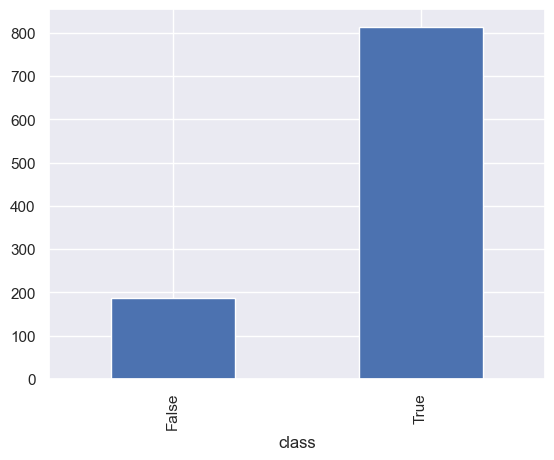

In [11]:
preview_dfs['review']['class'] = preview_dfs['review']['stars'] > 2
preview_dfs['review']['class'].value_counts().sort_index().plot.bar()

In [12]:
sampling_coef_bad = preview_dfs['review']['class'].value_counts()[False]/preview_dfs['review']['class'].value_counts()[True]

## Extraction d'un échantillons de reviews

### Recensement des catégories de business

In [13]:
business = pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'business.json', lines=True)
business['_cats'] = business['categories'].apply(lambda x: [cat.strip() for cat in x.split(',')] if x else [])
business['_cats'].sample(5)

100113                        [Restaurants, American (New)]
72827     [Ethnic Food, Specialty Food, Food, Internatio...
108571    [Pubs, Coffee & Tea, Sandwiches, Wine Bars, Ga...
94516     [Limos, Airport Shuttles, Taxis, Hotels & Trav...
19338     [Health & Medical, Medical Centers, Orthotics,...
Name: _cats, dtype: object

In [14]:
categories = set()
for index in business.index:
    categories.update(business.loc[index, '_cats'])

In [15]:
[categorie for categorie in categories if 'restaurant' in categorie.lower()]

['Pop-Up Restaurants', 'Restaurant Supplies', 'Restaurants']

In [16]:
[categorie for categorie in categories if 'food' in categorie.lower()]

['Food Court',
 'Seafood Markets',
 'Comfort Food',
 'Do-It-Yourself Food',
 'Food Banks',
 'Ethnic Food',
 'Live/Raw Food',
 'Food Stands',
 'Food',
 'Food Trucks',
 'Imported Food',
 'Seafood',
 'Fast Food',
 'Soul Food',
 'Food Delivery Services',
 'Specialty Food',
 'Food Tours']

### Création des fichiers parquets

- par chunk de 100000
- Filtrage des reviews sur categorie "restaurants"
- Séparation par note
- Ajout des infos business
- Limite en quantité

In [115]:
restaurants_ids = business[~business['categories'].isna() & business['categories'].str.contains('Restaurants')]['business_id'].to_list()
print(f'{len(restaurants_ids)} business sont des Restaurants')

52268 business sont des Restaurants


In [18]:
reviews_files = {stars:WORK_DATASET_DIR + f'reviews_stars_{stars}.parquet' for stars in range(1,6)}
reviews_counts = {stars:0 for stars in range(1,6)}
reviews_append = {stars:False for stars in range(1,6)}

business['review_count_q'] = pd.qcut(business.review_count, q=4, labels=['c1', 'c2', 'c3', 'c4'])
if EXTRACT_PARQUET:
    for chunk in pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'review.json', lines=True, chunksize=10000):
        restaurant_reviews = chunk[chunk['business_id'].isin(restaurants_ids)].copy()
        restaurant_reviews = restaurant_reviews.join(business.set_index('business_id'), on='business_id', rsuffix='_business')

        for stars in reviews_counts:
            if reviews_counts[stars] < SAMPLING_REVIEW_SIZE:
                reviews = restaurant_reviews[restaurant_reviews['stars'] == stars]
                keep_rows = min(SAMPLING_REVIEW_SIZE - reviews_counts[stars], reviews.shape[0])
                reviews_counts[stars] = reviews_counts[stars] + keep_rows
                reviews.iloc[:keep_rows].to_parquet(reviews_files[stars], engine='fastparquet', append=reviews_append[stars])
                reviews_append[stars] = True

        if sum([reviews_counts[i] for i in reviews_counts]) == SAMPLING_REVIEW_SIZE*len(reviews_counts): break

def get_reviews(max_stars = 2, stars = None):
    if stars:
        return pd.read_parquet(reviews_files[stars])
        
    df = pd.DataFrame()
    for stars in range(1, max_stars + 1):
        df = pd.concat([df, pd.read_parquet(reviews_files[stars])])
    return df

In [136]:
get_reviews(max_stars=1).dtypes

review_id                 object
user_id                   object
business_id               object
stars                      int64
useful                     int64
funny                      int64
cool                       int64
text                      object
date              datetime64[ns]
name                      object
address                   object
city                      object
state                     object
postal_code               object
latitude                 float64
longitude                float64
stars_business           float64
review_count               int64
is_open                    int64
attributes                object
categories                object
hours                     object
_cats                     object
review_count_q            object
dtype: object

## Analyse des echantillons de reviews 

### Nuages de mots par note

In [19]:
def review_word_cloud(reviews, min_df = 4, max_df = 100, verbose = 0):

    # Duplicates
    nb_duplicated = reviews.duplicated(subset='text').sum()
    reviews.drop_duplicates(subset='text', keep='first', inplace=True)

    if verbose > 0:
        print(f'Nombre de textes dupliqués supprimés: {nb_duplicated}')
        print(f'Il y a {reviews.shape[0]} enregistrements')

    if verbose > 0: display(reviews.sample(5, random_state=0).loc[:, ['stars', 'text']])
    
    # Initialize paralellize and sampling
    pandarallel.initialize(progress_bar=(verbose > 0), verbose=False)
    
    # Preprocess
    if verbose > 0: print('\nPreprocess\n=================\n')
    reviews['text'] = reviews['text'].parallel_apply(preprocess_text)

    # Preprocess (tokenize, lemmatization)
    if verbose > 0: print('\nTokenize\n=================\n')
    reviews['tokens'] = reviews['text'].parallel_apply(tokenize)
    reviews.drop(columns=['text'], inplace=True)
    
    # Remove words by frequency
    if verbose > 0: 
        print(f'\nSuppression par fréquence\n=================')
        print(f'  - {max_df} mots les plus fréquents')
        print(f'  - apparaisant moins de {min_df} fois\n')

    stop_words, nb_words_original = get_stop_words(reviews, min_df, max_df, verbose)
    reviews['tokens'] = reviews['tokens'].parallel_apply(drop_words, args=(stop_words,))
    reviews['text_len'] = reviews['tokens'].str.join(' ').str.len()

    if verbose > 0:
        print('')
        tokens_infos = [
            ['Nombre de tokens unique initial dans le dataframe', nb_words_original],
            ['Nombre de stopwords', len(stop_words)],
            ['Nombre de tokens unique restant dans le dataframe', len(set(reviews['tokens'].sum()))]
        ]
        print(tabulate(tokens_infos))

    # View result sample
    if verbose > 0: 
        print('\nEchantillon du resultat\n=================\n')
        display(reviews.sample(5, random_state=0).loc[:, ['stars', 'tokens']])

    # Calc and view text lengths
    if verbose > 0: 
        print('\nAnalyse des longeurs de text\n=================\n')
        reviews.boxplot(column='text_len', showfliers=True, vert=False)
        plt.show()

    # Text length
    total_text_len = reviews['text_len'].sum()
    if verbose > 0: 
        print(f'Longeur total du texte dans le dataframe: {total_text_len}')
        print('')

    # Visualisation Word clound on sample
    cloud_sample_size = min(reviews.shape[0], 1000)
    if verbose > 0: print(f'\nVisualisation du nuage de mot d\'un échantillon de {cloud_sample_size} lignes\n=================\n')
    sample_text = ' '.join(reviews.sample(cloud_sample_size, random_state=0)['tokens'].str.join(' ').values)
    word_cloud(text=sample_text)
    print('')

Note = 5


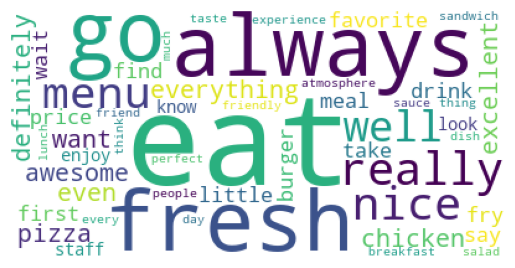


Note = 4


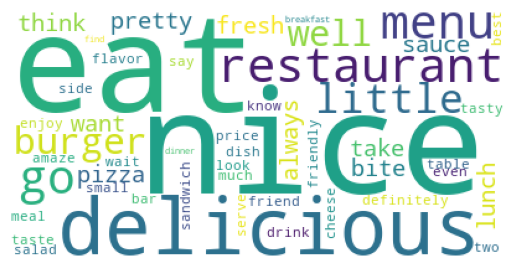


Note = 3


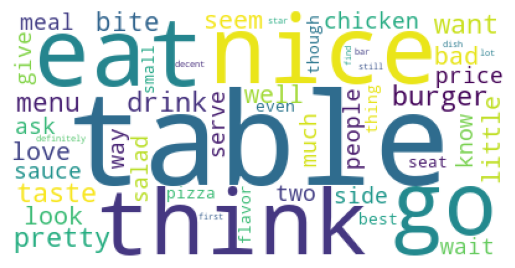


Note = 2


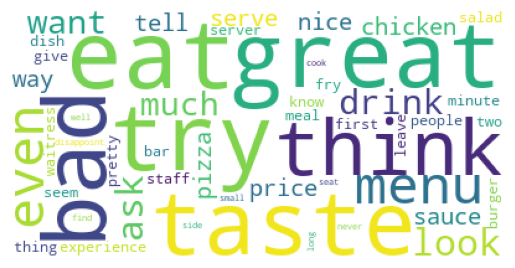


Note = 1


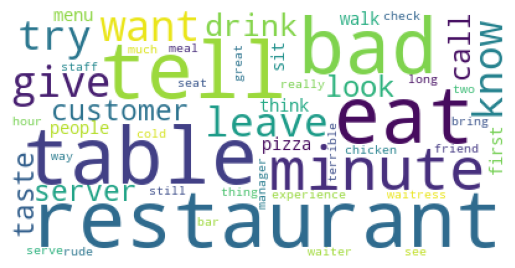

In [20]:
for stars in range(5,0,-1):
    print(f'Note = {stars}')
    review_word_cloud(reviews=get_reviews(stars=stars),
                      min_df=2,
                      max_df=20)

### Sac de mots (TF-IDF) et visualisation (PCA/TSNE)

In [145]:
def tf_idf(reviews, min_df = 4, max_df = 100, tsne_targets = [], pca_targets = [], verbose = 0):

    # Duplicates
    nb_duplicated = reviews.duplicated(subset='text').sum()
    reviews.drop_duplicates(subset='text', keep='first', inplace=True)

    if verbose > 0:
        print(f'Nombre de textes dupliqués supprimés: {nb_duplicated}')
        print(f'Il y a {reviews.shape[0]} enregistrements')
    
    if verbose > 1: display(reviews.sample(5, random_state=0))


    vectorizer = TfidfVectorizer(tokenizer=tokenize, token_pattern=None, preprocessor=preprocess_text, min_df=min_df, max_df=max_df, stop_words="english", sublinear_tf=True,ngram_range=(1,2))
    values = vectorizer.fit_transform(reviews['text'])

    if verbose > 0:
        print('\nVecteurs TF-IDF des reviews:\n====================')
        df = pd.DataFrame(values.toarray(), columns=vectorizer.get_feature_names_out())
        display(df.head())
        
        reviews_vecteurs = []
        reviews.reset_index(inplace=True)
        for index in reviews[reviews['text'].str.len() < 500].sample(5, random_state=0).index:
            review_tfidf = df.iloc[index][df.iloc[index] > 0].to_dict()
            reviews_vecteurs.append([reviews.iloc[index]['text'] , '\n'.join([f'{token}: {tfidf:.4f}' for token, tfidf in review_tfidf.items()])])
        print(tabulate(reviews_vecteurs, headers=['text review', 'vecteur tf-idf'], tablefmt="grid", maxcolwidths=[100, None]))

    if len(pca_targets) > 0:
        fig, axs = plt.subplots(1, len(pca_targets), figsize=(5*len(pca_targets),5))
        for key,target in enumerate(pca_targets):
            pca = PCA(n_components=2)
            X_pca = pca.fit_transform(values.toarray())
            pca_df = pd.DataFrame(X_pca, columns=['x', 'y'])
            pca_df[target] = reviews[target]
            ax = sns.scatterplot(data=pca_df, x='x', y='y', hue=target, alpha=0.6, ax=axs[key])

            # Fx labels
            f1 = ', '.join(vectorizer.get_feature_names_out()[np.flip(np.argsort(pca.components_[0])[-5:])]) + '...'
            f2 = ', '.join(vectorizer.get_feature_names_out()[np.flip(np.argsort(pca.components_[1])[-5:])]) + '...' 
    
            ax.set(xlabel=f'F1: {f1}',
                   ylabel=f'F2: {f2}',
                   title='PCA')
        plt.show()

    if len(tsne_targets) > 0:
        fig, axs = plt.subplots(1, len(tsne_targets) , figsize=(5*len(tsne_targets),5))
        for key,target in enumerate(tsne_targets):
            X_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=35).fit_transform(values)
            tsne_df = pd.DataFrame(X_tsne, columns=['x', 'y'])
            tsne_df[target] = reviews[target]
            sns.scatterplot(data=tsne_df, x='x', y='y', hue=target, ax=axs[key])
        plt.show()

Nombre de textes dupliqués supprimés: 0
Il y a 2000 enregistrements

Vecteurs TF-IDF des reviews:


,100,1st,2nd,able,absolute,absolutely,accept,accommodate,acknowledge,act,...,yell,yelp,yes,yesterday,york,young,yuck,yummy,zero,zero star
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.262554,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.212173,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


+------------------------------------------------------------------------------------------------------+--------------------------+
| text review                                                                                          | vecteur tf-idf           |
+======================================================================================================+==========================+
| You don't accept cash?  I don't think you grasp the ramifications of such a corpo-fascist economic   | accept: 0.3480           |
| principle.  No room for arrogant commies in my diet thank you so very very little.  Can't wait to    | attention: 0.2933        |
| see this place nosedive  For anyone in the dark about this policy,  watch Mike Judge's film,         | cash: 0.3238             |
| Idiocracy. Pay close attention throughout the hospital scene.   "Unscannable!!!"                     | close: 0.2257            |
|                                                                           

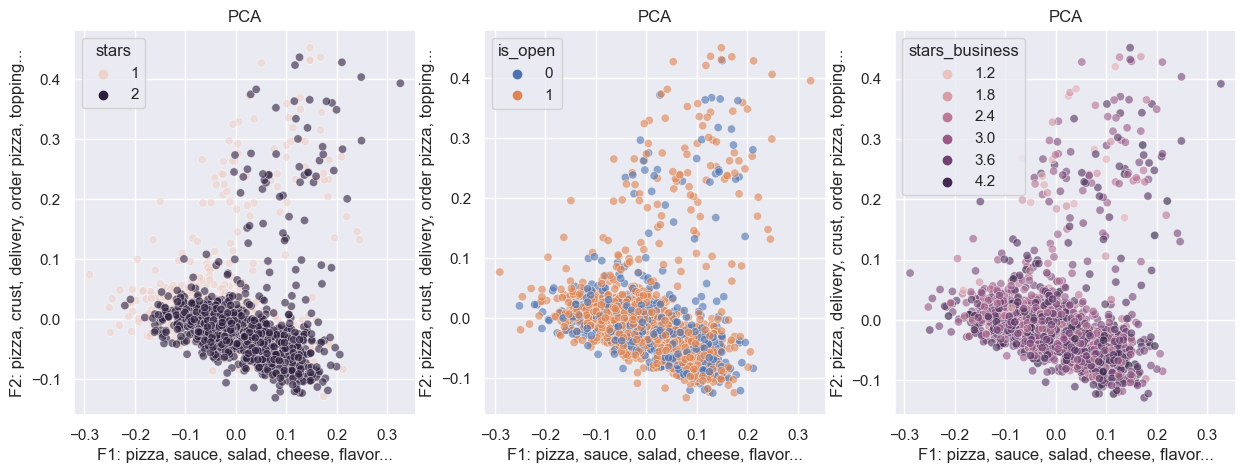

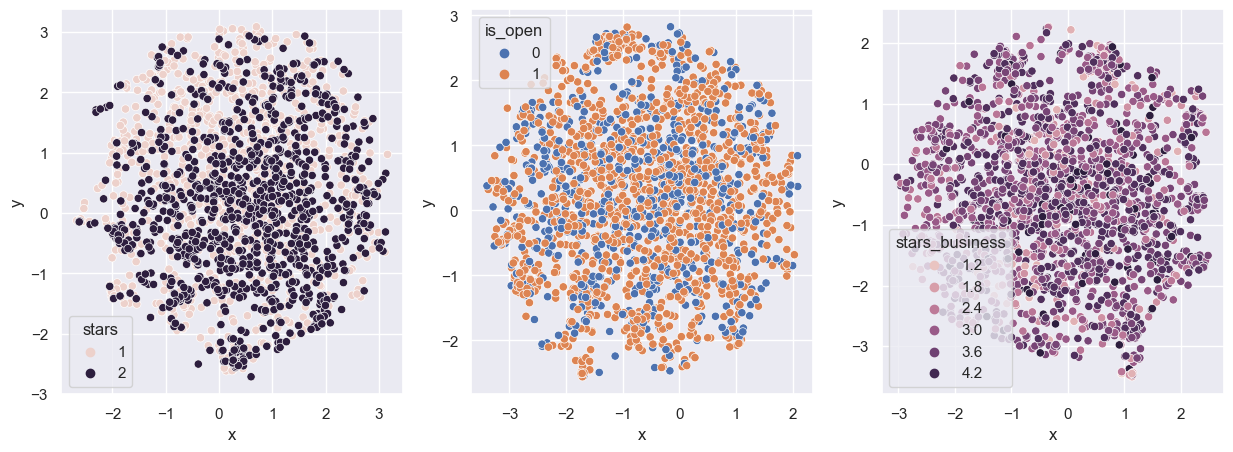

In [146]:
reviews = get_reviews(max_stars=2)
tf_idf(reviews=reviews,
       min_df=10,
       max_df=0.1,
       pca_targets=['stars', 'is_open', 'stars_business'],
       tsne_targets=['stars', 'is_open', 'stars_business'],
       verbose=1)

## Recherche des sujets d'insatisfactions

In [147]:
def find_topics(reviews, model = 'lda', min_df = 4, max_df = 100, n_topics = 10, n_topic_top_words=10, ngram_range=(1,1), verbose = 0):

    # pandas width
    pd_width = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', 300)

    topics = get_topics(reviews, model = model, min_df = 4, max_df = 100, n_topics=n_topics, n_top_words=n_topic_top_words, ngram_range=ngram_range, verbose=verbose)

    # Restore pandas width
    pd.set_option('display.max_colwidth', pd_width)
    
    return topics

In [148]:
topics = find_topics(reviews=get_reviews(max_stars=2),
                     model='lda',
                     min_df=2,
                     max_df=0.1,
                     n_topics=5, 
                     n_topic_top_words=5,
                     ngram_range=(1,3),
                     verbose=3)

  - Vectorisation (tf-idf)
  - Modélisation LDA
  - Affichage des topics

  Topic n°  Categories
----------  ---------------------------------------------------
         0  very disappoint, awful, kitchen, change, put hold
         1  bueno, unsatisfied, price food, domino, couldn get
         2  beer, roll, breakfast, taco, average
         3  staff rude, drink get, get work, wifi, question
         4  taste horrible, trick, service too, hat, food taste


In [113]:
topics = find_topics(reviews=get_reviews(max_stars=2),
                     model='nmf',
                     min_df=2,
                     max_df=0.1,
                     n_topics=5, 
                     n_topic_top_words=5,
                     ngram_range=(2,3),
                     verbose=3)

  - Vectorisation (tf-idf)
  - Modélisation NMF
  - Affichage des topics

  Topic n°  Categories
----------  -----------------------------------------------------------------------------------
         0  not good, food not, much good, not very, very good
         1  win back, try place, food price, good food, food time
         2  would not, not recommend, would not recommend, recommend place, not recommend place
         3  get food, take minute, customer service, wait minute, first time
         4  very disappoint, look like, saturday even, taco bell, nothing special


In [114]:
topics_grid = []
start = time.time()
LINE_UP = '\033[1A'
LINE_CLEAR = '\x1b[2K'

min_df_range = [2, 10]
max_df_range = [0.1, 0.3]
n_topics_range = [5]
n_grams_range = [(1,2),(2,3),(3,3)]
model_range = ['lda', 'nmf']

total_loops = len(min_df_range)*len(max_df_range) * len(n_topics_range) * len(n_grams_range) * len(model_range)
current_loop = 1
for min_df in min_df_range:
    for max_df in max_df_range:
        for n_topics in n_topics_range:
            for ngram_range in n_grams_range:
                for model in model_range:
                    print(f'Recherche {current_loop}/{total_loops}')
                    print(f'Temps écoulé {time_from(start)}')
                    print(f'Parametres:')
                    hyper_params = [['model', model], ['Fréquence minimal d\'un mot', min_df], ['Top des mots les plus fréquent supprimés', max_df], ['N Grams', ngram_range], ['Nombre de topics', n_topics]]
                    print(tabulate(hyper_params,))
                    topics = find_topics(reviews=get_reviews(max_stars=2),
                                         model = model,
                                         min_df=min_df,
                                         max_df=max_df,
                                         n_topics=n_topics, 
                                         n_topic_top_words=5,
                                         ngram_range=ngram_range,
                                         verbose=0)
                    current_loop = current_loop + 1
                    clear_output()
                    topics_grid.append({'params': 'model\nmin_df\nmax_df\nn_grams' ,
                                        'value': model + '\n' + str(min_df) + '\n' + str(max_df) + '\n' + str(ngram_range),
                                        'topics': '\n'.join([str(topic[0]) + ' : ' + topic[1] for topic in topics])
                                       })

print(f'{total_loops} boucles éxécutées en {time_from(start)}\n\n')
print(tabulate(topics_grid,  headers="keys", tablefmt="grid"))
        

12 boucles éxécutées en 2mn 10s


+----------+---------+-------------------------------------------------------------------------------------------------------+
| params   | value   | topics                                                                                                |
+==========+=========+=======================================================================================================+
| model    | lda     | 0 : bueno, unsatisfied, price food, get service, food cold                                            |
| min_df   | 2       | 1 : never bother, call ask, staff rude, hang, question                                                |
| max_df   | 0.1     | 2 : deli, wawa, state, zero, taste old                                                                |
| n_grams  | (1, 2)  | 3 : beer, roll, breakfast, taco, steak                                                                |
|          |         | 4 : drink get, get work, wifi, chicken tender, hard ro

# Classifications des images

## Prévisualisation du dataset

In [237]:
df_photos = pd.read_json('data/original/yelp_photos/photos.json', lines=True)
df_photos.sample(5)

,photo_id,business_id,caption,label
132838,M_giuY-SCNM8SFeIJYJqCw,SaLWfZgtvgwvqI9dHhHW5g,,food
133276,HHpm0oZZBN6VXceKVyE9sg,zYyVEC0IF86xSHF3GFmvkg,Gulab jamin,drink
61031,i1cWH9Vdcv9Ye9Htt7gDPg,AahCxtL9ZrcaeTpP23X8Ig,,inside
121655,dZSd8XBr9jPife8vlT9dkw,vhDWGF-8BfsxvS7Zo5Wv2w,,inside
93291,hZ57-pSJFwtUJS-cU-GZoA,B2u8anybTXox0SiUOqIAfg,M7: The Big Apple LARGE,food


In [238]:
df_photos.shape

(200100, 4)

In [239]:
df_photos.label.value_counts()

label
food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: count, dtype: int64

In [266]:
photo_ids = []
for label in df_photos.label.unique():
    photo_ids = photo_ids + list(df_photos[df_photos.label == label].sample(SAMPLING_PHOTOS_SIZE, random_state=0)['photo_id'])

df_photos_sampling = pd.DataFrame({'photo_id': photo_ids, 'width': np.zeros(len(photo_ids)), 'height': np.zeros(len(photo_ids)), 'mode': np.full(len(photo_ids), '')})

## Pretraitement des images

In [355]:
def preprocess_images(df_photo_sampling):
    for index in df_photos_sampling.index:
        photo_id = df_photos_sampling.iloc[index]['photo_id']
        img = Image.open(ORIGINAL_PHOTOS_DIR + 'photos/' + photo_id + '.jpg')
        
        w, h = img.size
        df_photos_sampling.loc[df_photos_sampling['photo_id']==photo_id, 'height'] = h   
        df_photos_sampling.loc[df_photos_sampling['photo_id']==photo_id, 'width'] = w
        df_photos_sampling.loc[df_photos_sampling['photo_id']==photo_id, 'mode'] = img.mode

def histo_rgb(path, dispay_img = True):
    Image.open(path)
    display(img)
    r, g, b = img.split()
    fig, axs = plt.subplots(1,3, figsize=(10,5), sharey=True)
    chans = {'rouge': r, 'vert': g, 'bleu':b}
    for index, name in enumerate(chans):
        chan_flat = np.array(chans[name]).flatten()
        ax = sns.histplot(chan_flat, bins=range(256), ax=axs[index])
        ax.set(ylabel=None,
               title=f'Channel: {name}')
    fig.supxlabel('Intensité')
    fig.supylabel('Nombre de pixels')
    plt.show()

def filtre_bruit(img):
    pass

def egalize_histogram():
    pass

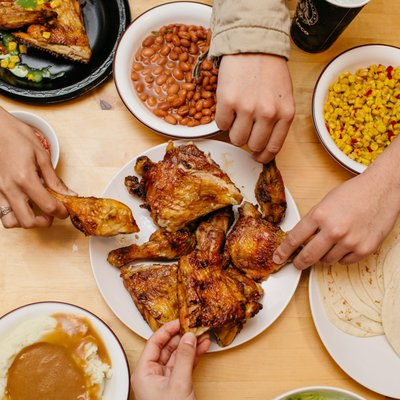

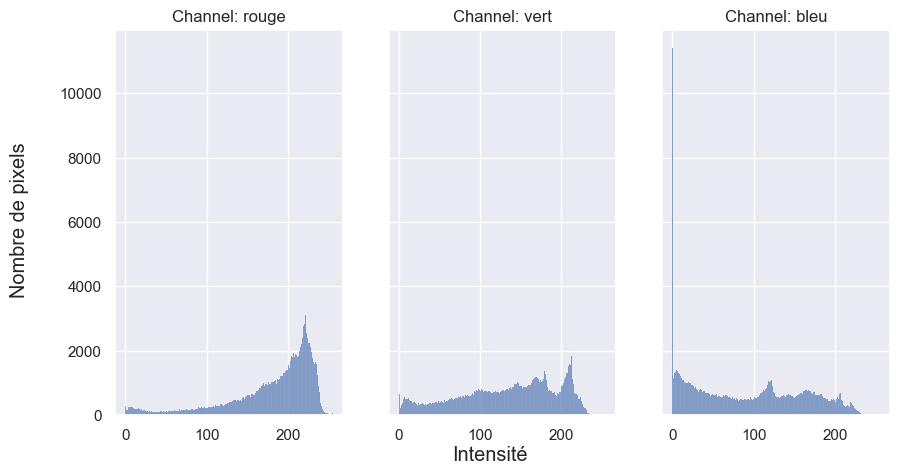

In [356]:
histo_rgb('data/original/yelp_photos/photos/__02nEL2xViYvZihvV4_hw.jpg')

In [268]:
set_images_infos(df_photo_sampling)

In [269]:
df_photos_sampling(.head()

,photo_id,width,height,mode
0,4bCgKE0Itp0T8wQXpYsypg,458.0,400.0,RGB
1,RN1AVvw1HXLceaNJkI0GdQ,300.0,400.0,RGB
2,XDVvq4N-wZV5jKVSUYXI2Q,300.0,400.0,RGB
3,IBCtJNh1XJApQSCSzLznlw,533.0,400.0,RGB
4,XIiiz9u9TY5CWjWlUW4pOg,533.0,400.0,RGB


In [270]:
df_photos_sampling.describe()

,width,height
count,500.000000,500.000000
mean,438.882000,389.688000
std,131.985303,32.814085
min,131.000000,69.000000
25%,300.000000,400.000000
50%,408.000000,400.000000
75%,543.750000,400.000000
max,600.000000,400.000000


In [272]:
df_photos_sampling['mode'].value_counts()

mode
RGB    500
Name: count, dtype: int64